### Rishu Raj Singh (2023AIB2080)

## Configuration 3

In [1]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.2 MB/s eta 0:00:00


In [2]:
import math
from dataclasses import dataclass
import os
import numpy as np
import sacrebleu
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas
torch.manual_seed(0)
import random
random.seed(0)
import  pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchinfo import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
SRC = "en"
TRG = "fr"
en_vocab_size = 5000
fr_vocab_size = 5000
vocab_sizes = {"en": en_vocab_size, "fr": fr_vocab_size}
max_seq_len = 70

In [4]:
full_set = pandas.read_csv("/kaggle/input/dataset-2/eng_-french.csv")

temp_train_set, test_set = train_test_split(full_set, test_size=0.3, random_state=42)
full_train_set, valid_set = train_test_split(temp_train_set, test_size=0.1, random_state=42)

print(len(full_train_set), len(valid_set), len(test_set))

110640 12294 52687


In [5]:
full_train_set.head(3)

,English words/sentences,French words/sentences
1660,That hurts.,Ça fait mal.
89279,I can't function without you.,Je n'arrive pas à fonctionner sans toi.
144858,Let's talk about what you did in Boston.,Parlons de ce que tu as fait à Boston.


In [6]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, decoders

# This library has been used only for tokenization purpose because French sentences contains 
# distinct type of character which is diificult to capture normally.

def get_tokenizers(dataset, train_set_size):
    en_sentences = dataset['English words/sentences'].iloc[:train_set_size].tolist()
    fr_sentences = dataset['French words/sentences'].iloc[:train_set_size].tolist()

    # Write English and French sentences to temporary files
    en_file = 'temp_en_sentences.txt'
    fr_file = 'temp_fr_sentences.txt'
    with open(en_file, 'w', encoding='utf-8') as f_en, open(fr_file, 'w', encoding='utf-8') as f_fr:
        for en_sent, fr_sent in zip(en_sentences, fr_sentences):
            f_en.write(en_sent + '\n')
            f_fr.write(fr_sent + '\n')

    # Initialize a tokenizer
    en_tokenizer = Tokenizer(models.BPE())
    fr_tokenizer = Tokenizer(models.BPE())

    # Customize pre-tokenization and decoding
    en_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    fr_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    en_tokenizer.decoder = decoders.BPEDecoder()
    fr_tokenizer.decoder = decoders.BPEDecoder()

    en_tokenizer.train([en_file], trainer=trainers.BpeTrainer(vocab_size=en_vocab_size, special_tokens=["<pad>"]))
    fr_tokenizer.train([fr_file], trainer=trainers.BpeTrainer(vocab_size=fr_vocab_size, special_tokens=["<pad>"]))

    # Define the tokenization and detokenization functions
    tokenizers = {"en": lambda sent: en_tokenizer.encode(sent).ids, "fr": lambda sent: fr_tokenizer.encode(sent).ids}
    detokenizers = {"en": lambda ids: ' '.join([en_tokenizer.id_to_token(id) for id in ids]), 
                    "fr": lambda ids: ' '.join([fr_tokenizer.id_to_token(id) for id in ids])}
    # Cleanup temporary files
    os.remove(en_file)
    os.remove(fr_file)

    return tokenizers, detokenizers


In [7]:
tokenizers, detokenizers = get_tokenizers(full_train_set, len(full_set))
print(tokenizers['fr']("De quoi ai-je l'air ?"))
print(tokenizers['en']('How do I look?'))

# indexes of special symbols
UNK, BOS, EOS, PAD = 0, 1, 2, 3







[645, 238, 106, 10, 167, 63, 6, 488, 25]
[238, 114, 32, 274, 23]


In [8]:
def tokenize_dataset(dataset):
    """
    Tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences.
    """
    if SRC == "en":
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for src_text, trg_text in dataset]
    else:
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for trg_text, src_text in dataset]
    

class TranslationDataset(Dataset):
    'create a dataset for torch.utils.data.DataLoader() '
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def pad_sequence(batch):
    'collate function for padding sentences such that all \
    the sentences in the batch have the same length'
    src_seqs  = [src for src, trg in batch]
    trg_seqs  = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs,
                                batch_first=True, padding_value = PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs,
                                batch_first=True, padding_value = PAD)
    return src_padded, trg_padded

In [9]:
batch_size = 16

class Dataloaders:
    'Dataloaders contains train_loader, test_loader and valid_loader for training and evaluation '
    def __init__(self):
        # train_set = list(full_train_set)[0:train_set_size]
        train_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in full_train_set.iterrows()]
        valid_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in valid_set.iterrows()]
        test_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in test_set.iterrows()]
        # print(train_set)
        train_dataset = TranslationDataset(tokenize_dataset(train_set_1))
        valid_dataset = TranslationDataset(tokenize_dataset(valid_set_1))
        test_dataset  = TranslationDataset(tokenize_dataset(test_set_1))

        # each batch returned by dataloader will be padded such that all the texts in
        # that batch have the same length as the longest text in that batch
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn = pad_sequence)

        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

        self.valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

In [10]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size
        # 1) Linear projections to get the multi-head query, key and value tensors
        # x_query, x_key, x_value dimension: nbatch * seq_len * d_embed
        # LHS query, key, value dimensions: nbatch * h * seq_len * d_k
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        # 2) Attention
        # scores has dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        # 3) Mask out padding tokens and future tokens
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        # p_atten dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        # x dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        # x now has dimensions:nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) # final linear layer


class ResidualConnection(nn.Module):
    '''residual connection: x + dropout(sublayer(layernorm(x))) '''
    def __init__(self, dim, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, sublayer):
        return x + self.drop(sublayer(self.norm(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_embed, max_seq_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_embed = d_embed
        # Compute the positional encodings in log space
        pe = torch.zeros(max_seq_len, d_embed)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2).float() * (-math.log(10000.0) / d_embed))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encodings to the input embeddings
        return x + self.pe[:, :x.size(1), :]


class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed) 
        self.pos_embed = PositionalEncoding(config.d_embed, config.max_seq_len)
        # self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x = self.pos_embed(x)
        x = self.dropout(x)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)



class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = PositionalEncoding(config.d_embed, config.max_seq_len)
        # self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)
    
    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg)
        x = self.pos_embed(x)
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) 
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)


In [11]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [12]:
def translate(model, x):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[BOS]*dB]).view(dB, 1).to(DEVICE)
        x_pad_mask = (x == PAD).view(x.size(0), 1, 1, x.size(-1)).to(DEVICE)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == PAD).view(y.size(0), 1, 1, y.size(-1)).to(DEVICE)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(DEVICE)
    return y

def remove_pad(sent):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(EOS)>0:
      sent = sent[0:sent.index(EOS)+1]
    while sent and sent[-1] == PAD:
            sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, num_batch=None):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            translation = translate(model, src)
            trg_out = trg_out.view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[TRG], trg_out[i]) for i in range(len(src))]
            cans = cans + [decode_sentence(detokenizers[TRG], translation[i]) for i in range(len(src))]
            if num_batch and idx>=num_batch:
                break
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
            print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
            print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
        return np.mean(bleus)

In [13]:
def train_epoch(model, dataloaders):
    model.train()
    grad_norm_clip = 1.0
    losses = []
    num_batches = len(dataloaders.train_loader)
    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (x, y) in pbar:
        optimizer.zero_grad()
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
        pred = pred.view(-1, pred.size(-1))
        loss = loss_fn(pred, trg_out).to(DEVICE)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        losses.append(loss.item())
        # report progress
        if idx > 0 and idx % 50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}')
    return np.mean(losses)


def validate(model, dataloder):
    'compute the validation loss'
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloder):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = pred.view(-1, pred.size(-1))
            losses.append(loss_fn(pred, trg_out).item())
    return np.mean(losses)

def compute_accuracy(model, dataloader):
    'compute the validation accuracy'
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = torch.argmax(pred, dim=-1)  # Get the indices of the maximum value along the last dimension
            # Flatten trg_out to match pred for comparison
            trg_out_flat = trg_out.view(-1)
            correct = (pred.view(-1) == trg_out_flat).sum().item()
            total_correct += correct
            total_samples += trg_out_flat.size(0)
    accuracy = total_correct / total_samples
    return accuracy

In [14]:
config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC],
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=128,
                     d_ff=1024,
                     h=32,
                     N_encoder=3,
                     N_decoder=3,
                     max_seq_len=max_seq_len,
                     dropout=0.1
                     )


# Initialize model
model = make_model(config)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

dataloaders = Dataloaders()

# Set up training loop
num_epochs = 200
train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):

    best_valid_loss = float('inf')
    train_size = len(dataloaders.train_loader) * batch_size
    train_loss = train_epoch(model, dataloaders)
    train_losses.append(train_loss)
    valid_loss = validate(model, dataloaders.valid_loader)
    valid_losses.append(valid_loss)

    # Calculate validation accuracy
    valid_accuracy = compute_accuracy(model, dataloaders.valid_loader)
    valid_accuracies.append(valid_accuracy)


    print(f'ep:{epoch+1} train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}, valid_accuracy={valid_accuracy:.5f}')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


# print("train set examples:")
# train_bleu = evaluate(model, dataloaders.train_loader, 20)
# print("validation set examples:")
# valid_bleu = evaluate(model, dataloaders.valid_loader)
# print("test set examples:")
# test_bleu  = evaluate(model, dataloaders.test_loader)


train loss=2.388: 100%|██████████| 6915/6915 [03:04<00:00, 37.52it/s]


ep:1 train_loss=2.75641, valid_loss=2.19235, valid_accuracy=0.64278


train loss=2.350: 100%|██████████| 6915/6915 [03:03<00:00, 37.59it/s]


ep:2 train_loss=2.10771, valid_loss=1.91195, valid_accuracy=0.67886


train loss=1.785: 100%|██████████| 6915/6915 [03:03<00:00, 37.77it/s]


ep:3 train_loss=1.86602, valid_loss=1.69735, valid_accuracy=0.70197


train loss=1.569: 100%|██████████| 6915/6915 [03:06<00:00, 37.06it/s]


ep:4 train_loss=1.68124, valid_loss=1.53725, valid_accuracy=0.72086


train loss=1.252: 100%|██████████| 6915/6915 [03:04<00:00, 37.47it/s]


ep:5 train_loss=1.53136, valid_loss=1.39999, valid_accuracy=0.73981


train loss=1.191: 100%|██████████| 6915/6915 [03:04<00:00, 37.50it/s]


ep:6 train_loss=1.40258, valid_loss=1.28526, valid_accuracy=0.75699


train loss=0.903: 100%|██████████| 6915/6915 [03:04<00:00, 37.49it/s]


ep:7 train_loss=1.29455, valid_loss=1.19347, valid_accuracy=0.77174


train loss=1.401: 100%|██████████| 6915/6915 [03:03<00:00, 37.77it/s]


ep:8 train_loss=1.20570, valid_loss=1.11551, valid_accuracy=0.78264


train loss=0.983: 100%|██████████| 6915/6915 [03:02<00:00, 37.85it/s]


ep:9 train_loss=1.12924, valid_loss=1.06024, valid_accuracy=0.79306


train loss=0.756: 100%|██████████| 6915/6915 [03:02<00:00, 37.83it/s]


ep:10 train_loss=1.06352, valid_loss=1.00415, valid_accuracy=0.80052


train loss=0.866: 100%|██████████| 6915/6915 [03:08<00:00, 36.74it/s]


ep:11 train_loss=1.00805, valid_loss=0.96353, valid_accuracy=0.80773


train loss=0.987: 100%|██████████| 6915/6915 [03:03<00:00, 37.68it/s]


ep:12 train_loss=0.95983, valid_loss=0.92131, valid_accuracy=0.81512


train loss=1.007: 100%|██████████| 6915/6915 [03:02<00:00, 37.93it/s]


ep:13 train_loss=0.91732, valid_loss=0.89255, valid_accuracy=0.81951


train loss=0.995: 100%|██████████| 6915/6915 [03:03<00:00, 37.73it/s]


ep:14 train_loss=0.88000, valid_loss=0.87023, valid_accuracy=0.82289


train loss=0.659: 100%|██████████| 6915/6915 [03:03<00:00, 37.63it/s]


ep:15 train_loss=0.84918, valid_loss=0.84229, valid_accuracy=0.82661


train loss=0.809: 100%|██████████| 6915/6915 [03:03<00:00, 37.74it/s]


ep:16 train_loss=0.81765, valid_loss=0.81899, valid_accuracy=0.83333


train loss=0.960: 100%|██████████| 6915/6915 [03:01<00:00, 38.03it/s]


ep:17 train_loss=0.79103, valid_loss=0.79716, valid_accuracy=0.83649


train loss=0.897: 100%|██████████| 6915/6915 [03:01<00:00, 38.08it/s]


ep:18 train_loss=0.76683, valid_loss=0.78416, valid_accuracy=0.83969


train loss=0.763: 100%|██████████| 6915/6915 [03:01<00:00, 38.16it/s]


ep:19 train_loss=0.74487, valid_loss=0.76932, valid_accuracy=0.84158


train loss=0.706: 100%|██████████| 6915/6915 [03:04<00:00, 37.54it/s]


ep:20 train_loss=0.72307, valid_loss=0.75511, valid_accuracy=0.84465


train loss=0.935: 100%|██████████| 6915/6915 [03:06<00:00, 37.11it/s]


ep:21 train_loss=0.70604, valid_loss=0.74157, valid_accuracy=0.84622


train loss=0.906: 100%|██████████| 6915/6915 [03:08<00:00, 36.65it/s]


ep:22 train_loss=0.68743, valid_loss=0.72708, valid_accuracy=0.84814


train loss=0.543: 100%|██████████| 6915/6915 [03:11<00:00, 36.04it/s]


ep:23 train_loss=0.67185, valid_loss=0.72157, valid_accuracy=0.85021


train loss=0.756: 100%|██████████| 6915/6915 [03:07<00:00, 36.83it/s]


ep:24 train_loss=0.65479, valid_loss=0.71358, valid_accuracy=0.85243


train loss=0.547: 100%|██████████| 6915/6915 [03:04<00:00, 37.40it/s]


ep:25 train_loss=0.64277, valid_loss=0.70047, valid_accuracy=0.85277


train loss=0.574: 100%|██████████| 6915/6915 [03:03<00:00, 37.62it/s]


ep:26 train_loss=0.63076, valid_loss=0.69876, valid_accuracy=0.85542


train loss=0.446: 100%|██████████| 6915/6915 [03:04<00:00, 37.45it/s]


ep:27 train_loss=0.61533, valid_loss=0.69294, valid_accuracy=0.85506


train loss=0.789: 100%|██████████| 6915/6915 [03:05<00:00, 37.18it/s]


ep:28 train_loss=0.60484, valid_loss=0.68000, valid_accuracy=0.85797


train loss=0.547: 100%|██████████| 6915/6915 [03:03<00:00, 37.59it/s]


ep:29 train_loss=0.59381, valid_loss=0.68303, valid_accuracy=0.85842


train loss=0.473: 100%|██████████| 6915/6915 [03:04<00:00, 37.46it/s]


ep:30 train_loss=0.58160, valid_loss=0.66829, valid_accuracy=0.86012


train loss=0.671: 100%|██████████| 6915/6915 [03:03<00:00, 37.78it/s]


ep:31 train_loss=0.57390, valid_loss=0.67530, valid_accuracy=0.86014


train loss=0.468: 100%|██████████| 6915/6915 [03:06<00:00, 37.09it/s]


ep:32 train_loss=0.56365, valid_loss=0.66674, valid_accuracy=0.86094


train loss=0.488: 100%|██████████| 6915/6915 [03:04<00:00, 37.52it/s]


ep:33 train_loss=0.55351, valid_loss=0.65915, valid_accuracy=0.86174


train loss=0.553: 100%|██████████| 6915/6915 [03:07<00:00, 36.83it/s]


ep:34 train_loss=0.54495, valid_loss=0.65525, valid_accuracy=0.86436


train loss=0.283: 100%|██████████| 6915/6915 [03:05<00:00, 37.35it/s]


ep:35 train_loss=0.53645, valid_loss=0.65411, valid_accuracy=0.86391


train loss=0.282: 100%|██████████| 6915/6915 [03:09<00:00, 36.42it/s]


ep:36 train_loss=0.52930, valid_loss=0.64901, valid_accuracy=0.86583


train loss=0.429: 100%|██████████| 6915/6915 [03:08<00:00, 36.75it/s]


ep:37 train_loss=0.52041, valid_loss=0.64495, valid_accuracy=0.86488


train loss=0.522: 100%|██████████| 6915/6915 [03:10<00:00, 36.35it/s]


ep:38 train_loss=0.51363, valid_loss=0.64225, valid_accuracy=0.86631


train loss=0.672: 100%|██████████| 6915/6915 [03:08<00:00, 36.61it/s]


ep:39 train_loss=0.50632, valid_loss=0.63646, valid_accuracy=0.86666


train loss=0.594: 100%|██████████| 6915/6915 [03:09<00:00, 36.54it/s]


ep:40 train_loss=0.50014, valid_loss=0.63496, valid_accuracy=0.86846


train loss=0.430: 100%|██████████| 6915/6915 [03:05<00:00, 37.38it/s]


ep:41 train_loss=0.49364, valid_loss=0.63232, valid_accuracy=0.86781


train loss=0.549: 100%|██████████| 6915/6915 [03:07<00:00, 36.91it/s]


ep:42 train_loss=0.48768, valid_loss=0.63075, valid_accuracy=0.86867


train loss=0.371: 100%|██████████| 6915/6915 [03:07<00:00, 36.97it/s]


ep:43 train_loss=0.48196, valid_loss=0.62531, valid_accuracy=0.86915


train loss=0.292: 100%|██████████| 6915/6915 [03:03<00:00, 37.65it/s]


ep:44 train_loss=0.47709, valid_loss=0.62445, valid_accuracy=0.86965


train loss=0.353: 100%|██████████| 6915/6915 [03:07<00:00, 36.96it/s]


ep:45 train_loss=0.46900, valid_loss=0.62203, valid_accuracy=0.86992


train loss=0.573: 100%|██████████| 6915/6915 [03:05<00:00, 37.37it/s]


ep:46 train_loss=0.46361, valid_loss=0.62339, valid_accuracy=0.87032


train loss=0.505: 100%|██████████| 6915/6915 [03:07<00:00, 36.91it/s]


ep:47 train_loss=0.46042, valid_loss=0.62479, valid_accuracy=0.87079


train loss=0.471: 100%|██████████| 6915/6915 [03:07<00:00, 36.97it/s]


ep:48 train_loss=0.45432, valid_loss=0.61696, valid_accuracy=0.87070


train loss=0.458: 100%|██████████| 6915/6915 [03:09<00:00, 36.54it/s]


ep:49 train_loss=0.44986, valid_loss=0.61391, valid_accuracy=0.87186


train loss=0.349: 100%|██████████| 6915/6915 [03:07<00:00, 36.98it/s]


ep:50 train_loss=0.44406, valid_loss=0.61873, valid_accuracy=0.87314


train loss=0.510: 100%|██████████| 6915/6915 [03:06<00:00, 36.99it/s]


ep:51 train_loss=0.43971, valid_loss=0.61497, valid_accuracy=0.87318


train loss=0.285: 100%|██████████| 6915/6915 [03:03<00:00, 37.59it/s]


ep:52 train_loss=0.43576, valid_loss=0.61414, valid_accuracy=0.87271


train loss=0.538: 100%|██████████| 6915/6915 [03:05<00:00, 37.27it/s]


ep:53 train_loss=0.43086, valid_loss=0.61654, valid_accuracy=0.87301


train loss=0.469: 100%|██████████| 6915/6915 [03:05<00:00, 37.28it/s]


ep:54 train_loss=0.42722, valid_loss=0.61561, valid_accuracy=0.87253


train loss=0.579: 100%|██████████| 6915/6915 [03:05<00:00, 37.33it/s]


ep:55 train_loss=0.42248, valid_loss=0.61597, valid_accuracy=0.87388


train loss=0.431: 100%|██████████| 6915/6915 [03:04<00:00, 37.49it/s]


ep:56 train_loss=0.41802, valid_loss=0.61436, valid_accuracy=0.87445


train loss=0.408: 100%|██████████| 6915/6915 [03:05<00:00, 37.20it/s]


ep:57 train_loss=0.41398, valid_loss=0.60999, valid_accuracy=0.87434


train loss=0.430: 100%|██████████| 6915/6915 [03:04<00:00, 37.40it/s]


ep:58 train_loss=0.41103, valid_loss=0.60924, valid_accuracy=0.87554


train loss=0.339: 100%|██████████| 6915/6915 [03:05<00:00, 37.33it/s]


ep:59 train_loss=0.40832, valid_loss=0.61255, valid_accuracy=0.87459


train loss=0.206: 100%|██████████| 6915/6915 [03:05<00:00, 37.19it/s]


ep:60 train_loss=0.40345, valid_loss=0.60792, valid_accuracy=0.87443


train loss=0.441: 100%|██████████| 6915/6915 [03:05<00:00, 37.21it/s]


ep:61 train_loss=0.40001, valid_loss=0.60583, valid_accuracy=0.87589


train loss=0.381: 100%|██████████| 6915/6915 [03:04<00:00, 37.39it/s]


ep:62 train_loss=0.39626, valid_loss=0.61139, valid_accuracy=0.87582


train loss=0.614: 100%|██████████| 6915/6915 [03:04<00:00, 37.41it/s]


ep:63 train_loss=0.39426, valid_loss=0.60579, valid_accuracy=0.87550


train loss=0.398: 100%|██████████| 6915/6915 [03:07<00:00, 36.92it/s]


ep:64 train_loss=0.38901, valid_loss=0.60387, valid_accuracy=0.87648


train loss=0.328: 100%|██████████| 6915/6915 [03:09<00:00, 36.56it/s]


ep:65 train_loss=0.38758, valid_loss=0.60676, valid_accuracy=0.87663


train loss=0.392: 100%|██████████| 6915/6915 [03:07<00:00, 36.86it/s]


ep:66 train_loss=0.38413, valid_loss=0.60476, valid_accuracy=0.87695


train loss=0.317: 100%|██████████| 6915/6915 [03:07<00:00, 36.81it/s]


ep:67 train_loss=0.38035, valid_loss=0.60425, valid_accuracy=0.87692


train loss=0.315: 100%|██████████| 6915/6915 [03:09<00:00, 36.46it/s]


ep:68 train_loss=0.37821, valid_loss=0.60395, valid_accuracy=0.87702


train loss=0.416: 100%|██████████| 6915/6915 [03:13<00:00, 35.80it/s]


ep:69 train_loss=0.37553, valid_loss=0.60295, valid_accuracy=0.87743


train loss=0.406: 100%|██████████| 6915/6915 [03:14<00:00, 35.58it/s]


ep:70 train_loss=0.37165, valid_loss=0.60094, valid_accuracy=0.87768


train loss=0.227: 100%|██████████| 6915/6915 [03:10<00:00, 36.39it/s]


ep:71 train_loss=0.36922, valid_loss=0.60347, valid_accuracy=0.87765


train loss=0.414: 100%|██████████| 6915/6915 [03:10<00:00, 36.25it/s]


ep:72 train_loss=0.36681, valid_loss=0.60394, valid_accuracy=0.87806


train loss=0.378: 100%|██████████| 6915/6915 [03:11<00:00, 36.03it/s]


ep:73 train_loss=0.36473, valid_loss=0.60581, valid_accuracy=0.87758


train loss=0.392: 100%|██████████| 6915/6915 [03:10<00:00, 36.39it/s]


ep:74 train_loss=0.36163, valid_loss=0.60457, valid_accuracy=0.87811


train loss=0.437: 100%|██████████| 6915/6915 [03:10<00:00, 36.33it/s]


ep:75 train_loss=0.35884, valid_loss=0.60368, valid_accuracy=0.87938


train loss=0.357: 100%|██████████| 6915/6915 [03:08<00:00, 36.64it/s]


ep:76 train_loss=0.35614, valid_loss=0.60694, valid_accuracy=0.87829


train loss=0.170: 100%|██████████| 6915/6915 [03:10<00:00, 36.31it/s]


ep:77 train_loss=0.35392, valid_loss=0.60578, valid_accuracy=0.87964


train loss=0.384: 100%|██████████| 6915/6915 [03:12<00:00, 36.01it/s]


ep:78 train_loss=0.35234, valid_loss=0.60535, valid_accuracy=0.87960


train loss=0.395: 100%|██████████| 6915/6915 [03:10<00:00, 36.25it/s]


ep:79 train_loss=0.34933, valid_loss=0.60724, valid_accuracy=0.87963


train loss=0.358: 100%|██████████| 6915/6915 [03:09<00:00, 36.53it/s]


ep:80 train_loss=0.34649, valid_loss=0.60681, valid_accuracy=0.87911


train loss=0.541: 100%|██████████| 6915/6915 [03:08<00:00, 36.60it/s]


ep:81 train_loss=0.34534, valid_loss=0.60349, valid_accuracy=0.87977


train loss=0.249: 100%|██████████| 6915/6915 [03:03<00:00, 37.65it/s]


ep:82 train_loss=0.34219, valid_loss=0.60523, valid_accuracy=0.87954


train loss=0.527: 100%|██████████| 6915/6915 [03:03<00:00, 37.59it/s]


ep:83 train_loss=0.34056, valid_loss=0.60315, valid_accuracy=0.87881


train loss=0.323: 100%|██████████| 6915/6915 [03:04<00:00, 37.42it/s]


ep:84 train_loss=0.33831, valid_loss=0.60816, valid_accuracy=0.87993


train loss=0.309: 100%|██████████| 6915/6915 [03:02<00:00, 37.89it/s]


ep:85 train_loss=0.33602, valid_loss=0.60746, valid_accuracy=0.87898


train loss=0.402: 100%|██████████| 6915/6915 [03:04<00:00, 37.39it/s]


ep:86 train_loss=0.33358, valid_loss=0.60731, valid_accuracy=0.88040


train loss=0.609: 100%|██████████| 6915/6915 [03:04<00:00, 37.48it/s]


ep:87 train_loss=0.33205, valid_loss=0.60560, valid_accuracy=0.88000


train loss=0.324: 100%|██████████| 6915/6915 [03:04<00:00, 37.48it/s]


ep:88 train_loss=0.32981, valid_loss=0.60860, valid_accuracy=0.87977


train loss=0.425: 100%|██████████| 6915/6915 [03:03<00:00, 37.65it/s]


ep:89 train_loss=0.32868, valid_loss=0.60547, valid_accuracy=0.88002


train loss=0.259: 100%|██████████| 6915/6915 [03:07<00:00, 36.96it/s]


ep:90 train_loss=0.32586, valid_loss=0.60788, valid_accuracy=0.88074


train loss=0.270: 100%|██████████| 6915/6915 [03:03<00:00, 37.71it/s]


ep:91 train_loss=0.32408, valid_loss=0.60673, valid_accuracy=0.88111


train loss=0.261: 100%|██████████| 6915/6915 [03:04<00:00, 37.48it/s]


ep:92 train_loss=0.32239, valid_loss=0.60752, valid_accuracy=0.88001


train loss=0.354: 100%|██████████| 6915/6915 [03:02<00:00, 37.86it/s]


ep:93 train_loss=0.31949, valid_loss=0.60120, valid_accuracy=0.88043


train loss=0.265: 100%|██████████| 6915/6915 [03:03<00:00, 37.70it/s]


ep:94 train_loss=0.31911, valid_loss=0.61417, valid_accuracy=0.88080


train loss=0.341: 100%|██████████| 6915/6915 [03:02<00:00, 37.82it/s]


ep:95 train_loss=0.31644, valid_loss=0.60410, valid_accuracy=0.88063


train loss=0.304: 100%|██████████| 6915/6915 [03:00<00:00, 38.24it/s]


ep:96 train_loss=0.31543, valid_loss=0.60810, valid_accuracy=0.88139


train loss=0.373: 100%|██████████| 6915/6915 [03:04<00:00, 37.39it/s]


ep:97 train_loss=0.31296, valid_loss=0.60801, valid_accuracy=0.88112


train loss=0.309: 100%|██████████| 6915/6915 [03:02<00:00, 37.95it/s]


ep:98 train_loss=0.31118, valid_loss=0.60913, valid_accuracy=0.88034


train loss=0.368: 100%|██████████| 6915/6915 [03:01<00:00, 38.05it/s]


ep:99 train_loss=0.31049, valid_loss=0.61037, valid_accuracy=0.88145


train loss=0.292: 100%|██████████| 6915/6915 [03:06<00:00, 37.08it/s]


ep:100 train_loss=0.30833, valid_loss=0.60800, valid_accuracy=0.88039


train loss=0.438: 100%|██████████| 6915/6915 [03:02<00:00, 37.83it/s]


ep:101 train_loss=0.30734, valid_loss=0.60848, valid_accuracy=0.88123


train loss=0.417: 100%|██████████| 6915/6915 [03:03<00:00, 37.63it/s]


ep:102 train_loss=0.30508, valid_loss=0.60993, valid_accuracy=0.88203


train loss=0.303: 100%|██████████| 6915/6915 [03:02<00:00, 37.87it/s]


ep:103 train_loss=0.30355, valid_loss=0.61225, valid_accuracy=0.88156


train loss=0.468: 100%|██████████| 6915/6915 [03:00<00:00, 38.30it/s]


ep:104 train_loss=0.30255, valid_loss=0.61660, valid_accuracy=0.88175


train loss=0.383: 100%|██████████| 6915/6915 [03:03<00:00, 37.73it/s]


ep:105 train_loss=0.29908, valid_loss=0.61451, valid_accuracy=0.88153


train loss=0.214: 100%|██████████| 6915/6915 [03:02<00:00, 37.88it/s]


ep:106 train_loss=0.29887, valid_loss=0.61229, valid_accuracy=0.88151


train loss=0.246: 100%|██████████| 6915/6915 [03:02<00:00, 37.91it/s]


ep:107 train_loss=0.29682, valid_loss=0.61256, valid_accuracy=0.88146


train loss=0.298: 100%|██████████| 6915/6915 [03:01<00:00, 38.20it/s]


ep:108 train_loss=0.29526, valid_loss=0.61240, valid_accuracy=0.88172


train loss=0.406: 100%|██████████| 6915/6915 [03:01<00:00, 38.09it/s]


ep:109 train_loss=0.29377, valid_loss=0.61211, valid_accuracy=0.88093


train loss=0.325: 100%|██████████| 6915/6915 [03:06<00:00, 37.16it/s]


ep:110 train_loss=0.29330, valid_loss=0.61153, valid_accuracy=0.88168


train loss=0.257: 100%|██████████| 6915/6915 [03:22<00:00, 34.18it/s]


ep:111 train_loss=0.29230, valid_loss=0.60899, valid_accuracy=0.88262


train loss=0.372: 100%|██████████| 6915/6915 [03:22<00:00, 34.21it/s]


ep:112 train_loss=0.29046, valid_loss=0.61068, valid_accuracy=0.88188


train loss=0.192: 100%|██████████| 6915/6915 [03:02<00:00, 37.94it/s]


ep:113 train_loss=0.28849, valid_loss=0.61137, valid_accuracy=0.88257


train loss=0.243: 100%|██████████| 6915/6915 [03:01<00:00, 38.01it/s]


ep:114 train_loss=0.28763, valid_loss=0.61153, valid_accuracy=0.88221


train loss=0.281: 100%|██████████| 6915/6915 [03:02<00:00, 37.86it/s]


ep:115 train_loss=0.28604, valid_loss=0.61483, valid_accuracy=0.88316


train loss=0.185: 100%|██████████| 6915/6915 [02:59<00:00, 38.54it/s]


ep:116 train_loss=0.28518, valid_loss=0.60902, valid_accuracy=0.88279


train loss=0.144: 100%|██████████| 6915/6915 [03:03<00:00, 37.65it/s]


ep:117 train_loss=0.28391, valid_loss=0.61686, valid_accuracy=0.88267


train loss=0.329: 100%|██████████| 6915/6915 [03:02<00:00, 37.92it/s]


ep:118 train_loss=0.28252, valid_loss=0.61605, valid_accuracy=0.88307


train loss=0.281: 100%|██████████| 6915/6915 [03:01<00:00, 38.02it/s]


ep:119 train_loss=0.28021, valid_loss=0.61708, valid_accuracy=0.88222


train loss=0.198: 100%|██████████| 6915/6915 [03:02<00:00, 37.83it/s]


ep:120 train_loss=0.28009, valid_loss=0.61763, valid_accuracy=0.88308


train loss=0.328: 100%|██████████| 6915/6915 [03:02<00:00, 37.98it/s]


ep:121 train_loss=0.27816, valid_loss=0.61866, valid_accuracy=0.88226


train loss=0.301: 100%|██████████| 6915/6915 [03:00<00:00, 38.34it/s]


ep:122 train_loss=0.27676, valid_loss=0.61718, valid_accuracy=0.88220


train loss=0.255: 100%|██████████| 6915/6915 [03:02<00:00, 37.98it/s]


ep:123 train_loss=0.27729, valid_loss=0.61655, valid_accuracy=0.88332


train loss=0.306: 100%|██████████| 6915/6915 [03:00<00:00, 38.28it/s]


ep:124 train_loss=0.27540, valid_loss=0.61800, valid_accuracy=0.88281


train loss=0.228: 100%|██████████| 6915/6915 [03:03<00:00, 37.63it/s]


ep:125 train_loss=0.27449, valid_loss=0.61514, valid_accuracy=0.88282


train loss=0.306: 100%|██████████| 6915/6915 [03:03<00:00, 37.75it/s]


ep:126 train_loss=0.27260, valid_loss=0.62201, valid_accuracy=0.88323


train loss=0.286: 100%|██████████| 6915/6915 [03:03<00:00, 37.77it/s]


ep:127 train_loss=0.27128, valid_loss=0.61988, valid_accuracy=0.88244


train loss=0.225: 100%|██████████| 6915/6915 [03:03<00:00, 37.73it/s]


ep:128 train_loss=0.27028, valid_loss=0.62111, valid_accuracy=0.88399


train loss=0.233: 100%|██████████| 6915/6915 [03:02<00:00, 37.86it/s]


ep:129 train_loss=0.26873, valid_loss=0.62081, valid_accuracy=0.88340


train loss=0.159: 100%|██████████| 6915/6915 [03:00<00:00, 38.37it/s]


ep:130 train_loss=0.26807, valid_loss=0.62025, valid_accuracy=0.88379


train loss=0.298: 100%|██████████| 6915/6915 [03:05<00:00, 37.36it/s]


ep:131 train_loss=0.26777, valid_loss=0.62172, valid_accuracy=0.88380


train loss=0.267: 100%|██████████| 6915/6915 [03:00<00:00, 38.29it/s]


ep:132 train_loss=0.26557, valid_loss=0.61761, valid_accuracy=0.88305


train loss=0.192: 100%|██████████| 6915/6915 [03:04<00:00, 37.56it/s]


ep:133 train_loss=0.26501, valid_loss=0.61829, valid_accuracy=0.88387


train loss=0.291: 100%|██████████| 6915/6915 [03:04<00:00, 37.58it/s]


ep:134 train_loss=0.26358, valid_loss=0.62024, valid_accuracy=0.88364


train loss=0.175: 100%|██████████| 6915/6915 [03:00<00:00, 38.29it/s]


ep:135 train_loss=0.26281, valid_loss=0.62141, valid_accuracy=0.88430


train loss=0.210: 100%|██████████| 6915/6915 [03:02<00:00, 37.98it/s]


ep:136 train_loss=0.26295, valid_loss=0.62653, valid_accuracy=0.88344


train loss=0.315: 100%|██████████| 6915/6915 [03:02<00:00, 37.88it/s]


ep:137 train_loss=0.26021, valid_loss=0.63060, valid_accuracy=0.88330


train loss=0.207: 100%|██████████| 6915/6915 [03:00<00:00, 38.29it/s]


ep:138 train_loss=0.25934, valid_loss=0.62929, valid_accuracy=0.88334


train loss=0.499: 100%|██████████| 6915/6915 [03:02<00:00, 37.96it/s]


ep:139 train_loss=0.25811, valid_loss=0.62371, valid_accuracy=0.88356


train loss=0.215: 100%|██████████| 6915/6915 [03:04<00:00, 37.50it/s]


ep:140 train_loss=0.25720, valid_loss=0.62529, valid_accuracy=0.88322


train loss=0.232: 100%|██████████| 6915/6915 [03:02<00:00, 37.95it/s]


ep:141 train_loss=0.25650, valid_loss=0.62267, valid_accuracy=0.88295


train loss=0.205: 100%|██████████| 6915/6915 [03:03<00:00, 37.64it/s]


ep:142 train_loss=0.25573, valid_loss=0.62827, valid_accuracy=0.88335


train loss=0.199: 100%|██████████| 6915/6915 [03:04<00:00, 37.42it/s]


ep:143 train_loss=0.25562, valid_loss=0.62671, valid_accuracy=0.88244


train loss=0.274: 100%|██████████| 6915/6915 [03:04<00:00, 37.39it/s]


ep:144 train_loss=0.25360, valid_loss=0.62873, valid_accuracy=0.88315


train loss=0.284: 100%|██████████| 6915/6915 [03:03<00:00, 37.76it/s]


ep:145 train_loss=0.25297, valid_loss=0.63040, valid_accuracy=0.88373


train loss=0.330: 100%|██████████| 6915/6915 [03:05<00:00, 37.35it/s]


ep:146 train_loss=0.25206, valid_loss=0.62881, valid_accuracy=0.88433


train loss=0.308: 100%|██████████| 6915/6915 [03:00<00:00, 38.22it/s]


ep:147 train_loss=0.25138, valid_loss=0.62865, valid_accuracy=0.88391


train loss=0.225: 100%|██████████| 6915/6915 [03:03<00:00, 37.61it/s]


ep:148 train_loss=0.24952, valid_loss=0.62769, valid_accuracy=0.88446


train loss=0.262: 100%|██████████| 6915/6915 [03:05<00:00, 37.26it/s]


ep:149 train_loss=0.24955, valid_loss=0.62673, valid_accuracy=0.88379


train loss=0.307: 100%|██████████| 6915/6915 [03:06<00:00, 37.03it/s]


ep:150 train_loss=0.24856, valid_loss=0.63370, valid_accuracy=0.88424


train loss=0.192: 100%|██████████| 6915/6915 [03:03<00:00, 37.72it/s]


ep:151 train_loss=0.24763, valid_loss=0.63030, valid_accuracy=0.88382


train loss=0.177: 100%|██████████| 6915/6915 [03:08<00:00, 36.61it/s]


ep:152 train_loss=0.24662, valid_loss=0.63397, valid_accuracy=0.88430


train loss=0.276: 100%|██████████| 6915/6915 [03:07<00:00, 36.88it/s]


ep:153 train_loss=0.24625, valid_loss=0.62776, valid_accuracy=0.88376


train loss=0.230: 100%|██████████| 6915/6915 [03:05<00:00, 37.20it/s]


ep:154 train_loss=0.24430, valid_loss=0.62542, valid_accuracy=0.88488


train loss=0.240: 100%|██████████| 6915/6915 [03:06<00:00, 37.17it/s]


ep:155 train_loss=0.24337, valid_loss=0.63593, valid_accuracy=0.88338


train loss=0.319: 100%|██████████| 6915/6915 [03:05<00:00, 37.33it/s]


ep:156 train_loss=0.24345, valid_loss=0.63115, valid_accuracy=0.88452


train loss=0.213: 100%|██████████| 6915/6915 [03:04<00:00, 37.38it/s]


ep:157 train_loss=0.24271, valid_loss=0.63221, valid_accuracy=0.88435


train loss=0.218: 100%|██████████| 6915/6915 [03:09<00:00, 36.49it/s]


ep:158 train_loss=0.24189, valid_loss=0.63480, valid_accuracy=0.88384


train loss=0.272: 100%|██████████| 6915/6915 [03:07<00:00, 36.89it/s]


ep:159 train_loss=0.24068, valid_loss=0.63115, valid_accuracy=0.88531


train loss=0.297: 100%|██████████| 6915/6915 [03:14<00:00, 35.59it/s]


ep:160 train_loss=0.23936, valid_loss=0.63711, valid_accuracy=0.88472


train loss=0.270: 100%|██████████| 6915/6915 [03:08<00:00, 36.68it/s]


ep:161 train_loss=0.23936, valid_loss=0.63586, valid_accuracy=0.88397


train loss=0.365: 100%|██████████| 6915/6915 [03:07<00:00, 36.81it/s]


ep:162 train_loss=0.23914, valid_loss=0.63891, valid_accuracy=0.88434


train loss=0.158: 100%|██████████| 6915/6915 [03:06<00:00, 37.01it/s]


ep:163 train_loss=0.23807, valid_loss=0.63116, valid_accuracy=0.88490


train loss=0.344: 100%|██████████| 6915/6915 [03:09<00:00, 36.40it/s]


ep:164 train_loss=0.23679, valid_loss=0.63768, valid_accuracy=0.88506


train loss=0.199: 100%|██████████| 6915/6915 [03:07<00:00, 36.82it/s]


ep:165 train_loss=0.23619, valid_loss=0.63270, valid_accuracy=0.88474


train loss=0.314: 100%|██████████| 6915/6915 [03:07<00:00, 36.91it/s]


ep:166 train_loss=0.23612, valid_loss=0.63502, valid_accuracy=0.88451


train loss=0.282: 100%|██████████| 6915/6915 [03:08<00:00, 36.72it/s]


ep:167 train_loss=0.23456, valid_loss=0.63861, valid_accuracy=0.88391


train loss=0.224: 100%|██████████| 6915/6915 [03:05<00:00, 37.19it/s]


ep:168 train_loss=0.23380, valid_loss=0.63383, valid_accuracy=0.88374


train loss=0.282: 100%|██████████| 6915/6915 [03:06<00:00, 36.98it/s]


ep:169 train_loss=0.23279, valid_loss=0.63837, valid_accuracy=0.88341


train loss=0.283: 100%|██████████| 6915/6915 [03:10<00:00, 36.32it/s]


ep:170 train_loss=0.23291, valid_loss=0.64293, valid_accuracy=0.88464


train loss=0.235: 100%|██████████| 6915/6915 [03:06<00:00, 37.04it/s]


ep:171 train_loss=0.23176, valid_loss=0.64047, valid_accuracy=0.88458


train loss=0.234: 100%|██████████| 6915/6915 [03:04<00:00, 37.44it/s]


ep:172 train_loss=0.23151, valid_loss=0.63962, valid_accuracy=0.88447


train loss=0.403: 100%|██████████| 6915/6915 [03:06<00:00, 37.02it/s]


ep:173 train_loss=0.23035, valid_loss=0.64625, valid_accuracy=0.88451


train loss=0.168: 100%|██████████| 6915/6915 [03:08<00:00, 36.71it/s]


ep:174 train_loss=0.22951, valid_loss=0.64549, valid_accuracy=0.88396


train loss=0.164: 100%|██████████| 6915/6915 [03:05<00:00, 37.18it/s]


ep:175 train_loss=0.22906, valid_loss=0.64332, valid_accuracy=0.88452


train loss=0.372: 100%|██████████| 6915/6915 [03:03<00:00, 37.65it/s]


ep:176 train_loss=0.22839, valid_loss=0.64358, valid_accuracy=0.88397


train loss=0.208: 100%|██████████| 6915/6915 [03:05<00:00, 37.35it/s]


ep:177 train_loss=0.22715, valid_loss=0.64174, valid_accuracy=0.88496


train loss=0.168: 100%|██████████| 6915/6915 [03:07<00:00, 36.87it/s]


ep:178 train_loss=0.22673, valid_loss=0.63630, valid_accuracy=0.88476


train loss=0.284: 100%|██████████| 6915/6915 [03:04<00:00, 37.49it/s]


ep:179 train_loss=0.22695, valid_loss=0.64534, valid_accuracy=0.88535


train loss=0.208: 100%|██████████| 6915/6915 [03:06<00:00, 37.13it/s]


ep:180 train_loss=0.22564, valid_loss=0.64078, valid_accuracy=0.88474


train loss=0.215: 100%|██████████| 6915/6915 [03:08<00:00, 36.77it/s]


ep:181 train_loss=0.22472, valid_loss=0.64840, valid_accuracy=0.88419


train loss=0.322: 100%|██████████| 6915/6915 [03:05<00:00, 37.32it/s]


ep:182 train_loss=0.22453, valid_loss=0.64469, valid_accuracy=0.88557


train loss=0.256: 100%|██████████| 6915/6915 [03:05<00:00, 37.27it/s]


ep:183 train_loss=0.22336, valid_loss=0.65045, valid_accuracy=0.88442


train loss=0.156: 100%|██████████| 6915/6915 [03:08<00:00, 36.74it/s]


ep:184 train_loss=0.22302, valid_loss=0.64736, valid_accuracy=0.88404


train loss=0.149: 100%|██████████| 6915/6915 [03:09<00:00, 36.47it/s]


ep:185 train_loss=0.22153, valid_loss=0.64582, valid_accuracy=0.88399


train loss=0.170: 100%|██████████| 6915/6915 [03:07<00:00, 36.79it/s]


ep:186 train_loss=0.22125, valid_loss=0.65097, valid_accuracy=0.88441


train loss=0.282: 100%|██████████| 6915/6915 [03:04<00:00, 37.49it/s]


ep:187 train_loss=0.22126, valid_loss=0.64829, valid_accuracy=0.88431


train loss=0.261: 100%|██████████| 6915/6915 [03:07<00:00, 36.82it/s]


ep:188 train_loss=0.22069, valid_loss=0.64080, valid_accuracy=0.88451


train loss=0.164: 100%|██████████| 6915/6915 [03:05<00:00, 37.27it/s]


ep:189 train_loss=0.22054, valid_loss=0.64733, valid_accuracy=0.88521


train loss=0.206: 100%|██████████| 6915/6915 [03:07<00:00, 36.93it/s]


ep:190 train_loss=0.21951, valid_loss=0.64253, valid_accuracy=0.88505


train loss=0.264: 100%|██████████| 6915/6915 [03:10<00:00, 36.29it/s]


ep:191 train_loss=0.21888, valid_loss=0.65052, valid_accuracy=0.88506


train loss=0.213: 100%|██████████| 6915/6915 [03:03<00:00, 37.77it/s]


ep:192 train_loss=0.21878, valid_loss=0.64541, valid_accuracy=0.88507


train loss=0.240: 100%|██████████| 6915/6915 [03:03<00:00, 37.64it/s]


ep:193 train_loss=0.21810, valid_loss=0.64958, valid_accuracy=0.88472


train loss=0.201: 100%|██████████| 6915/6915 [03:01<00:00, 38.01it/s]


ep:194 train_loss=0.21727, valid_loss=0.64751, valid_accuracy=0.88551


train loss=0.380: 100%|██████████| 6915/6915 [03:04<00:00, 37.50it/s]


ep:195 train_loss=0.21661, valid_loss=0.65257, valid_accuracy=0.88517


train loss=0.230: 100%|██████████| 6915/6915 [03:05<00:00, 37.29it/s]


ep:196 train_loss=0.21614, valid_loss=0.64683, valid_accuracy=0.88501


train loss=0.225: 100%|██████████| 6915/6915 [03:03<00:00, 37.72it/s]


ep:197 train_loss=0.21522, valid_loss=0.65195, valid_accuracy=0.88436


train loss=0.190: 100%|██████████| 6915/6915 [03:05<00:00, 37.32it/s]


ep:198 train_loss=0.21472, valid_loss=0.64768, valid_accuracy=0.88530


train loss=0.167: 100%|██████████| 6915/6915 [03:07<00:00, 36.88it/s]


ep:199 train_loss=0.21477, valid_loss=0.64895, valid_accuracy=0.88557


train loss=0.278: 100%|██████████| 6915/6915 [03:04<00:00, 37.50it/s]


ep:200 train_loss=0.21347, valid_loss=0.64791, valid_accuracy=0.88553


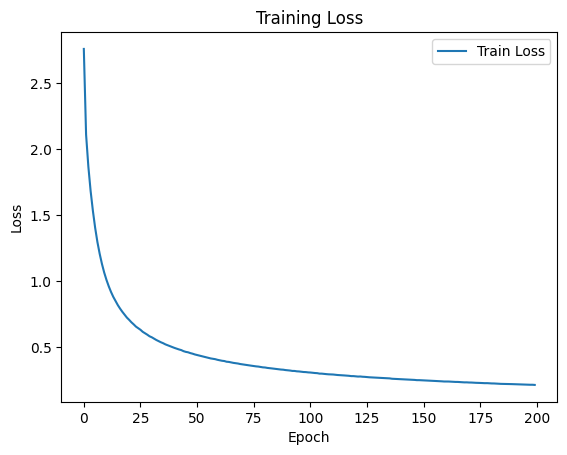

In [15]:
# Plot epoch-wise training loss
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

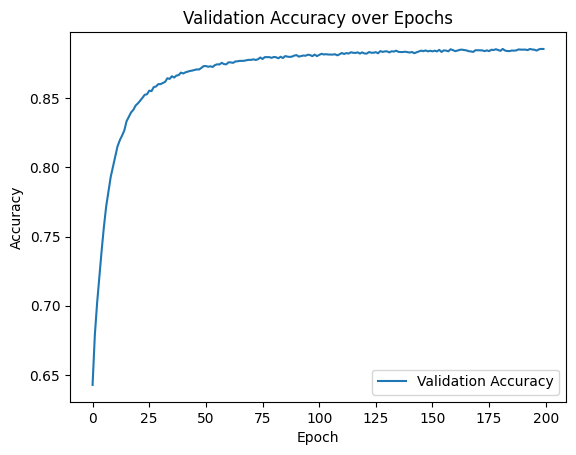

In [16]:
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [17]:
# Save the model
torch.save(model.state_dict(),'transformer_model_3.pth')

In [18]:
# Load the state dictionary from the saved file

# model.load_state_dict(torch.load('transformer_model.pth'))


Test_accuracy = compute_accuracy(model, dataloaders.test_loader)

print(f"Test Accuracy: {Test_accuracy:.5f}")

Test Accuracy: 0.88326


In [19]:
# Evaluate on test set
test_bleu_score = evaluate(model, dataloaders.test_loader,20)
print(f"Test BLEU Score: {test_bleu_score:.4f}")

src:  ! Tom and Mary aren ' t alone. "
trg:  Tom et Marie ne sont pas seuls. "
pred: ! Tom et Mary ne sont pas seuls. "
src:  ! You could ' ve said no. "
trg:  Tu aurais pu dire non. "
pred: ! Vous auriez pu dire non. "
src:  ! This doesn ' t make sense. "
trg:  Ça n ' a pas de sens. "
pred: ! Ça n ' a pas de sens. "
Test BLEU Score: 43.3775
